In [1]:
#!pip install -e git+https://github.com/casperbroch/ai-economist@stockmarket#egg=ai-economist

In [2]:
import time

In [3]:
# Define the configuration of the environment that will be built

env_config_dict = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'stock_market_simulation',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (1) Execute Circuit Breaker (planner action)
        ('ExecCircuitBreaker', {}),
        # (2) Buy Or Sell Stocks (agent action)
        ('BuyOrSellStocks', {}),
    ],
    
    'volume_importance': 1.0,
    'stock_price_history_length': 101,
    'stock_quantity': 200,
    

    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 4,          # Number of non-planner agents (must be > 1)
    'world_size': [1, 1], # [Height, Width] of the env world
    'episode_length': 100, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': False,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
    'dense_log_frequency': 1
}

In [4]:
from rllib.env_wrapper import RLlibEnvWrapper
env_obj = RLlibEnvWrapper({"env_config_dict": env_config_dict}, verbose=True)

Inside covid19_components.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.
Inside covid19_env.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.


C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-

[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
action_mask    : (21,)
time           : (1,)
world-Endogenous-AbleToBuy: (1,)
world-Endogenous-AbleToSell: (1,)
world-Endogenous-AvailableFunds: (1,)
world-Endogenous-Demand: (1,)
world-Endogenous-Labor: (1,)
world-Endogenous-NumberOfStocks: (1,)
world-Endogenous-StockPrice: (1,)
world-Endogenous-StockPriceHistory: (101,)
world-Endogenous-StocksLeft: (1,)
world-Endogenous-Supply: (1,)
world-Endogenous-TotalBalance: (1,)
world-Endogenous-Trust: (1,)
world-Endogenous-Volumes: (101,)


[EnvWrapper] Obs (p)   
action_mask    : (2,)
time           : (1,)
world-abl_trade: (1,)
world-avg_balance: (1,)


[EnvWrapper] Action (a) Discrete(21)
[EnvWrapper] Action (p) Discrete(2)


In [5]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

In [6]:
policies = {
    "a": (
        None,  # uses default policy
        env_obj.observation_space,
        env_obj.action_space,
        {}  # define a custom agent policy configuration.
    ),
    "p": (
        None,  # uses default policy
        env_obj.observation_space_pl,
        env_obj.action_space_pl,
        {}  # define a custom planner policy configuration.
    )
}

# In foundation, all the agents have integer ids and the social planner has an id of "p"
policy_mapping_fun = lambda i: "a" if str(i).isdigit() else "p"

policies_to_train = ["a", "p"]

In [7]:
trainer_config = {
    "multiagent": {
        "policies": policies,
        "policies_to_train": policies_to_train,
        "policy_mapping_fn": policy_mapping_fun,
    }
}

In [8]:
trainer_config.update(
    {
        "num_workers": 2,
        "num_envs_per_worker": 2,
        # Other training parameters
        "train_batch_size":  4000,
        "sgd_minibatch_size": 4000,
        "num_sgd_iter": 1,
        "lr": 0.00001,
    }
)

In [9]:
# We also add the "num_envs_per_worker" parameter for the env. wrapper to index the environments.
env_config = {
    "env_config_dict": env_config_dict,
    "num_envs_per_worker": trainer_config.get('num_envs_per_worker'),   
}

trainer_config.update(
    {
        "env_config": env_config        
    }
)

In [10]:
# Initialize Ray
ray.init(webui_host="127.0.0.1")

2024-05-12 16:07:43,116	INFO resource_spec.py:212 -- Starting Ray with 4.2 GiB memory available for workers and up to 2.1 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2024-05-12 16:07:44,055	INFO services.py:1165 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '192.168.1.93',
 'raylet_ip_address': '192.168.1.93',
 'redis_address': '192.168.1.93:6379',
 'object_store_address': 'tcp://127.0.0.1:61337',
 'raylet_socket_name': 'tcp://127.0.0.1:65188',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\caspe\\AppData\\Local\\Temp\\ray\\session_2024-05-12_16-07-43_111951_9092'}

In [11]:
# Create the PPO trainer.
trainer = PPOTrainer(
    env=RLlibEnvWrapper,
    config=trainer_config,
    )

2024-05-12 16:07:49,210	ERROR syncer.py:46 -- Log sync requires rsync to be installed.
2024-05-12 16:07:49,213	INFO trainer.py:585 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2024-05-12 16:07:49,213	INFO trainer.py:612 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=2120) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=2120)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=2120) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=2120)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=2120) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=2120)   _np_qint16 = np.dtype([("qint16", n

(pid=16612) Inside covid19_components.py: 0 GPUs are available.
(pid=16612) No GPUs found! Running the simulation on a CPU.
(pid=16612) Inside covid19_env.py: 0 GPUs are available.
(pid=16612) No GPUs found! Running the simulation on a CPU.
(pid=2120) Inside covid19_components.py: 0 GPUs are available.
(pid=2120) No GPUs found! Running the simulation on a CPU.
(pid=2120) Inside covid19_env.py: 0 GPUs are available.
(pid=2120) No GPUs found! Running the simulation on a CPU.


In [12]:
NUM_ITERS = 5
start_train = time.time()

for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    start = time.time()
    result = trainer.train()
    length = time.time() - start
    print(f'''episode_reward_mean: {result.get('episode_reward_mean')}''')
    print(f'''it_time_taken: {length}''')

    
length_train = time.time() - start_train
print("Training took", length_train, " seconds.")

********** Iter : 0 **********
(pid=2120) Average reward of planner after 101 days 0.504950495049505
(pid=2120) Average reward of planner after 101 days 0.5841584158415841
(pid=16612) Average reward of planner after 101 days 0.40594059405940597
(pid=16612) Average reward of planner after 101 days 0.44554455445544555
(pid=2120) Average reward of planner after 101 days 0.5000490148024703
(pid=2120) Average reward of planner after 101 days 0.5503382021370454
(pid=16612) Average reward of planner after 101 days 0.5188706989510832
(pid=16612) Average reward of planner after 101 days 0.47965885697480637
(pid=2120) Average reward of planner after 101 days 0.6089113763841829
(pid=2120) Average reward of planner after 101 days 0.5302013683379905
(pid=16612) Average reward of planner after 101 days 0.48038485840545625
(pid=16612) Average reward of planner after 101 days 0.5790065233363842
(pid=16612) Average reward of planner after 101 days 0.6087166817663907
(pid=16612) Average reward of planne

(pid=2120) Average reward of planner after 101 days 0.5785246349348878
(pid=2120) Average reward of planner after 101 days 0.5003921861650246
(pid=16612) Average reward of planner after 101 days 0.5304881493730448
(pid=16612) Average reward of planner after 101 days 0.49999995214601367
(pid=2120) Average reward of planner after 101 days 0.5106784617320286
(pid=2120) Average reward of planner after 101 days 0.4603999226352973
(pid=16612) Average reward of planner after 101 days 0.47059889256804993
(pid=16612) Average reward of planner after 101 days 0.5297029698232278
(pid=2120) Average reward of planner after 101 days 0.5694126580369507
(pid=16612) Average reward of planner after 101 days 0.5690158306194857
(pid=2120) Average reward of planner after 101 days 0.5788158408181713
(pid=16612) Average reward of planner after 101 days 0.5398980492061706
(pid=2120) Average reward of planner after 101 days 0.4709842837429401
(pid=2120) Average reward of planner after 101 days 0.570087285552655

(pid=2120) Average reward of planner after 101 days 0.5890118904125317
(pid=16612) Average reward of planner after 101 days 0.5102930027204893
(pid=2120) Average reward of planner after 101 days 0.5401902738153054
(pid=16612) Average reward of planner after 101 days 0.510499854021423
(pid=2120) Average reward of planner after 101 days 0.4909803157466588
(pid=16612) Average reward of planner after 101 days 0.559507851512084
(pid=16612) Average reward of planner after 101 days 0.5496089094457566
(pid=2120) Average reward of planner after 101 days 0.49049693340411193
episode_reward_mean: 50.65
it_time_taken: 13.219521045684814
Training took 69.61460971832275  seconds.


In [13]:
def generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
):
    dense_logs = {}
    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()   

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
        
            
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )
                
                
            #Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs['p'], 
                planner_states, 
                policy_id='p',
                full_fetch=False
            )

            obs, rew, done, info = env_obj.step(actions)        
            if done['__all__']:
                break
        dense_logs[idx] = env_obj.env.dense_log
    return dense_logs

In [14]:
def reward_function_planner(prices, index, volume, volumes, volume_weight=0.5):
    """
    Reward function to evaluate the current state of the market.
    
    Parameters:
        volume (float): Current volume of the market.
        std_dev (float): Current standard deviation of the market.
        volume_weight (float): Weight of volume in the reward calculation.
        
    Returns:
        float: Reward value.
    """
    
    # Gathered from base data
    AVERAGE_VOLUME = 27.61291121680539
    AVERAGE_STDV = 7.880280857892539
    
    # Get target values which the planner wants to achieve
    target_volume = 1.1 * AVERAGE_VOLUME
    target_std_dev = 0.9 * AVERAGE_STDV
    
    # Get standard deviation from past 5 timesteps
    std_dev = planner_metric_stability(prices, index)
    
    max_vol = max(volumes[:index+1])
            
    if max_vol == 0:
        vol_reward = 0.0
    else:
        vol_reward = volume/max_vol

    # Calculate std_dev deviation from target
    std_dev_deviation = abs(std_dev - target_std_dev) / target_std_dev
    
    #print("Max vol", max_vol)
    #print("vol reward",vol_reward)
    #print("stdv reward",1-std_dev_deviation)
    #print("")
    
    # Reward is a combination of volume and std_dev deviation
    reward = ((1 - volume_weight) * (1 - std_dev_deviation)) + (volume_weight * vol_reward)
    
    return reward

def planner_metric_stability(prices, index):
    if 1 < index < 10:
        price_diffs = [prices[i] - prices[i-1] for i in range(index)]
    elif index >= 10:
        price_diffs = [prices[i] - prices[i-1] for i in range(index-10, index)]
    else:
        return 0.0
    
    negative_diffs = [diff for diff in price_diffs if diff < 0]  # Filter only negative differences
    
    if len(negative_diffs) == 0:
        return 0.0
    
    std = np.std(negative_diffs)
    
    #file_path = 'C:\\Users\\caspe\\Desktop\\stdvs.csv'
    # Writing to CSV
    #with open(file_path, mode='a', newline='') as file:
    #    writer = csv.writer(file)
    #    writer.writerow([std])
    
    return std

In [15]:
dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
)

Average reward of planner after 101 days 0.48514851485148514


In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
agent_0_total_balance = [log["0"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_1_total_balance = [log["1"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_2_total_balance = [log["2"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_3_total_balance = [log["3"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]

stock_prices = [log["0"]["endogenous"]["StockPrice"] for log in dense_logs[0]['states']]

ranges = np.arange(0, 100 + 1, 2.0)

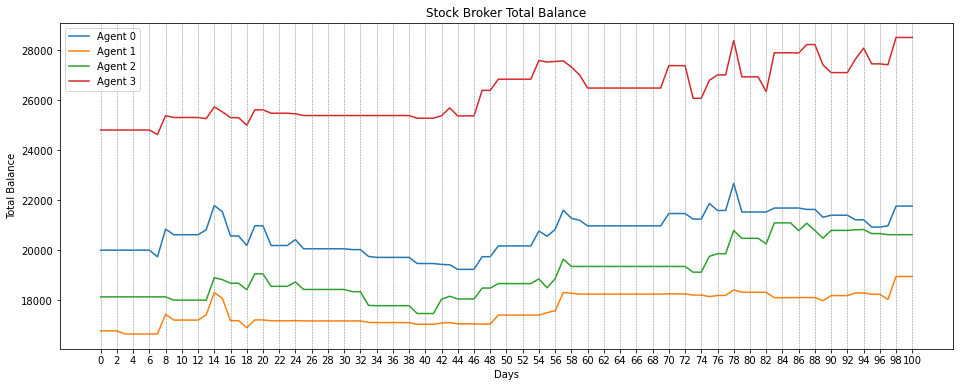

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(0,101),agent_0_total_balance, label="Agent 0")
plt.plot(np.arange(0,101),agent_1_total_balance, label="Agent 1")
plt.plot(np.arange(0,101),agent_2_total_balance, label="Agent 2")
plt.plot(np.arange(0,101),agent_3_total_balance, label="Agent 3")
plt.title('Stock Broker Total Balance')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Total Balance')
plt.xticks(ranges)

# Adding vertical lines at each xtick position
for xtick in ranges:
    plt.axvline(x=xtick, color='gray', linestyle='--', linewidth=0.5)
    
#plt.savefig("miners_green_scores.png")
plt.show()

In [19]:
volumes = [log["0"]["endogenous"]["Volumes"] for log in dense_logs[0]['states']]
stopped = [log["0"]["endogenous"]["AbleToBuy"] for log in dense_logs[0]['states']]
prices = [log["0"]["endogenous"]["StockPriceHistory"] for log in dense_logs[0]['states']]

agent_0_demand = [log["0"]["endogenous"]["Demand"] for log in dense_logs[0]['states']]
agent_1_demand = [log["1"]["endogenous"]["Demand"] for log in dense_logs[0]['states']]
agent_2_demand = [log["2"]["endogenous"]["Demand"] for log in dense_logs[0]['states']]
agent_3_demand = [log["3"]["endogenous"]["Demand"] for log in dense_logs[0]['states']]

agent_0_supply = [log["0"]["endogenous"]["Supply"] for log in dense_logs[0]['states']]
agent_1_supply = [log["1"]["endogenous"]["Supply"] for log in dense_logs[0]['states']]
agent_2_supply = [log["2"]["endogenous"]["Supply"] for log in dense_logs[0]['states']]
agent_3_supply = [log["3"]["endogenous"]["Supply"] for log in dense_logs[0]['states']]

agents_demands = [x + y + z + f for x, y, z, f in zip(agent_0_demand, agent_1_demand,agent_2_demand, agent_3_demand )]
agents_supplies = [x + y + z + f for x, y, z, f in zip(agent_0_supply, agent_1_supply,agent_2_supply, agent_3_supply )]

i=0
rewards=0
while i < 101:
    print("--- Summary of Day", i, "---")
    print("Price: ", prices[-1][i])
    reward = reward_function_planner(prices[-1], i, volumes[-1][i], volumes[-1], 1)
    rewards+=reward
    print("Reward", reward)
    print("Volume: ", volumes[-1][i])
    print("Demand: ", agents_demands[i], "  Supply: ", agents_supplies[i])
    demand = agents_demands[i]
    supply = agents_supplies[i]
    if demand+supply>0:
        test = (demand - supply) / (demand + supply)
        test = 0.05*test
        #print(test)
    else:
        pass
            #print(0)
    print("")
    i+=1
    
avg_reward = rewards / 101
print(avg_reward)



--- Summary of Day 0 ---
Price:  416.204303269881
Reward 0.0
Volume:  0.0
Demand:  0.0   Supply:  0.0

--- Summary of Day 1 ---
Price:  414.6887983613992
Reward 0.0
Volume:  0.0
Demand:  0.0   Supply:  0.0

--- Summary of Day 2 ---
Price:  410.8789226785178
Reward 0.0
Volume:  0.0
Demand:  0.0   Supply:  0.0

--- Summary of Day 3 ---
Price:  435.9661970509227
Reward 1.0
Volume:  20.0
Demand:  20.0   Supply:  0.0

--- Summary of Day 4 ---
Price:  433.45506506279474
Reward 0.0
Volume:  0.0
Demand:  0.0   Supply:  0.0

--- Summary of Day 5 ---
Price:  432.71959829221964
Reward 0.0
Volume:  0.0
Demand:  0.0   Supply:  0.0

--- Summary of Day 6 ---
Price:  429.71978319285245
Reward 0.0
Volume:  0.0
Demand:  0.0   Supply:  0.0

--- Summary of Day 7 ---
Price:  456.9013583685466
Reward 1.0
Volume:  69.0
Demand:  69.0   Supply:  0.0

--- Summary of Day 8 ---
Price:  450.6827804562524
Reward 0.6086956521739131
Volume:  42.0
Demand:  18.0   Supply:  24.0

--- Summary of Day 9 ---
Price:  460.100

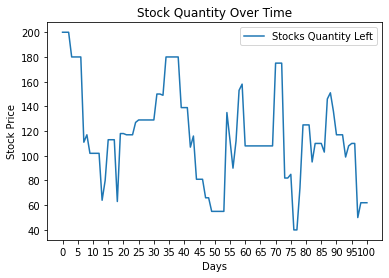

In [20]:
stocks_left = [log["0"]["endogenous"]["StocksLeft"] for log in dense_logs[0]['states']]

plt.plot(np.arange(0,101),stocks_left, label="Stocks Quantity Left")
plt.title('Stock Quantity Over Time')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.xticks(np.arange(0, 100+1, 5.0))
#plt.savefig("miners_green_scores.png")
plt.show()

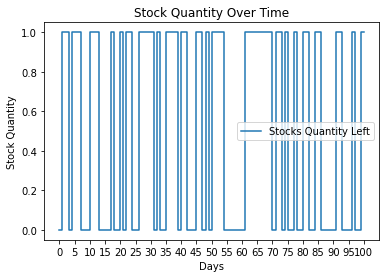

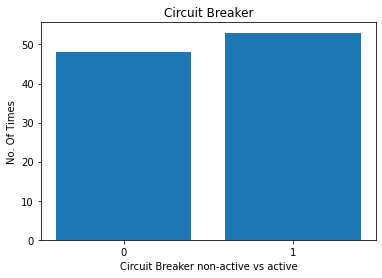

In [21]:

able_to_trade = [log["0"]["endogenous"]["AbleToBuy"] for log in dense_logs[0]['states']]
#Step Plot
plt.step(np.arange(0, 101), able_to_trade, label="Stocks Quantity Left", where='post')
plt.title('Stock Quantity Over Time')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Quantity')
plt.xticks(np.arange(0, 100+1, 5.0))
plt.show()

plt.hist(able_to_trade, bins=[-0.5, 0.5, 1.5], rwidth=0.8)
plt.title('Circuit Breaker')
plt.xlabel('Circuit Breaker non-active vs active')
plt.ylabel('No. Of Times')
plt.xticks([0, 1])

plt.show()

In [22]:
# Shutdown Ray after use
ray.shutdown()

In [23]:
#planner_gr_score_importances = [log["p"]["GreenScoreImportance"] for log in dense_logs[0]['states']]

In [24]:
#dense_logs[0]['states'][0]

No handles with labels found to put in legend.


ValueError: x and y must have same first dimension, but have shapes (3,) and (2,)

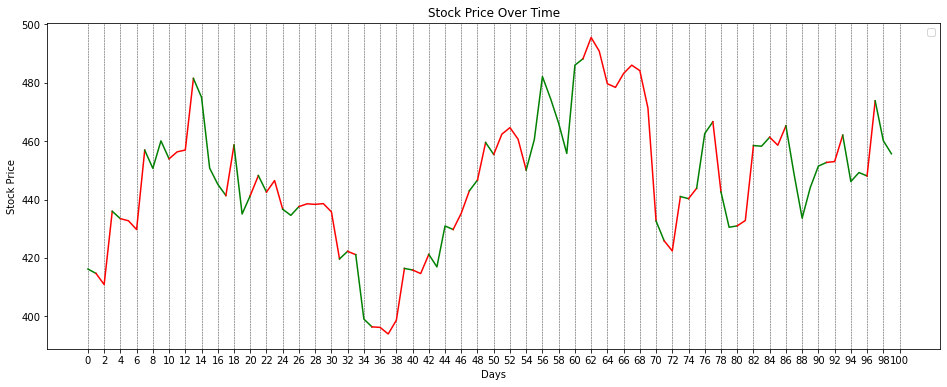

In [25]:
able_to_trade = np.array([log["0"]["endogenous"]["AbleToBuy"] for log in dense_logs[0]['states']])

plt.figure(figsize=(16, 6))
#plt.plot(np.arange(0, 101), stock_prices, label="Stock Price", color='blue')
plt.title('Stock Price Over Time')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.xticks(ranges)

# Adding vertical lines at each xtick position
for xtick in ranges:
    plt.axvline(x=xtick, color='gray', linestyle='--', linewidth=0.5)

for xtick in ranges:
    plt.axvline(x=xtick, color='gray', linestyle='--', linewidth=0.5)


# Find the intervals
array = able_to_trade
intervals = []
current_color = array[0]
start = 0
for i in range(len(array)):
    if array[i] != current_color:
        intervals.append((start, i, current_color))
        start = i
        current_color = array[i]
intervals.append((start, len(array), current_color))

# Plotting
for start, end, color in intervals:
    end += 1
    if color == 0:
        plt.plot(range(start, end), stock_prices[start:end], color='green')
    else:
        plt.plot(range(start, end), stock_prices[start:end], color='red')

plt.show()